
# <span style="color:rgb(213,80,0)">Run Motor Drive Simulation</span>

Copyright 2020-2022 The MathWorks, Inc.


In [1]:
% Specify test cases
clear testCases
idx=1;  testCases(idx).rpm = 1500;   testCases(idx).torque = 150;
idx=2;  testCases(idx).rpm =  700;   testCases(idx).torque =  50;
idx=3;  testCases(idx).rpm = -1500;  testCases(idx).torque = -150;
idx=4;  testCases(idx).rpm =  -700;  testCases(idx).torque =  -50;

% Load parameters
MotorDrive_testParams

% Open model and set up simulation
mdl = "MotorDrive_testHarness";
if not(bdIsLoaded(mdl)), open_system(mdl); end

set_param(mdl,...
  'FastRestart', 'off',...
  'SimscapeLogOpenViewer', 'off',...
  'EnablePacing', 'off',...
  'SolverType', 'Variable-step',...
  'Solver', 'VariableStepAuto',...
  'SaveTime', 'on',...
  'TimeSaveName', 'tout',...
  'SignalLogging', 'on',...
  'SignalLoggingName', 'logsout',...
  'SimscapeLogType', 'local',...
  'SimscapeLogSimulationStatistics', 'off',...
  'SimscapeLogToSDI', 'off',...
  'SimscapeLogName', 'logsoutssc',...
  'SimscapeLogDecimation', 1,...
  'SimscapeLogLimitData', 'off',...
  'ReturnWorkspaceOutputs', 'on',...
  'ReturnWorkspaceOutputsName', 'out');

nSims = numel(testCases);
clear in
in(1:nSims) = Simulink.SimulationInput(mdl);
for idx = 1:nSims
  rpm = testCases(idx).rpm;
  in(idx) = in(idx).setBlockParameter(mdl+"/Constant Target Speed", 'Value',num2str(rpm));
  in(idx) = in(idx).setBlockParameter(mdl+"/Load inertia", 'w',num2str(rpm));
  in(idx) = in(idx).setBlockParameter(mdl+"/Motor Drive/FEM-Parameterized PMSM",...
                                      'angular_velocity',num2str(rpm));
  in(idx) = in(idx).setBlockParameter(mdl+"/Motor Drive/FEM-Parameterized PMSM",...
                                      'angular_velocity_priority','High');

  torque = testCases(idx).torque;
  in(idx) = in(idx).setBlockParameter(mdl+"/Step Load Torque", 'After',num2str(torque));
end

% run simulation
out = sim(in);

[15-Dec-2023 15:50:49] Running simulations...
[15-Dec-2023 15:51:28] Completed 1 of 4 simulation runs
[15-Dec-2023 15:51:57] Completed 2 of 4 simulation runs
[15-Dec-2023 15:52:23] Completed 3 of 4 simulation runs
[15-Dec-2023 15:52:45] Completed 4 of 4 simulation runs

## Simulation Results


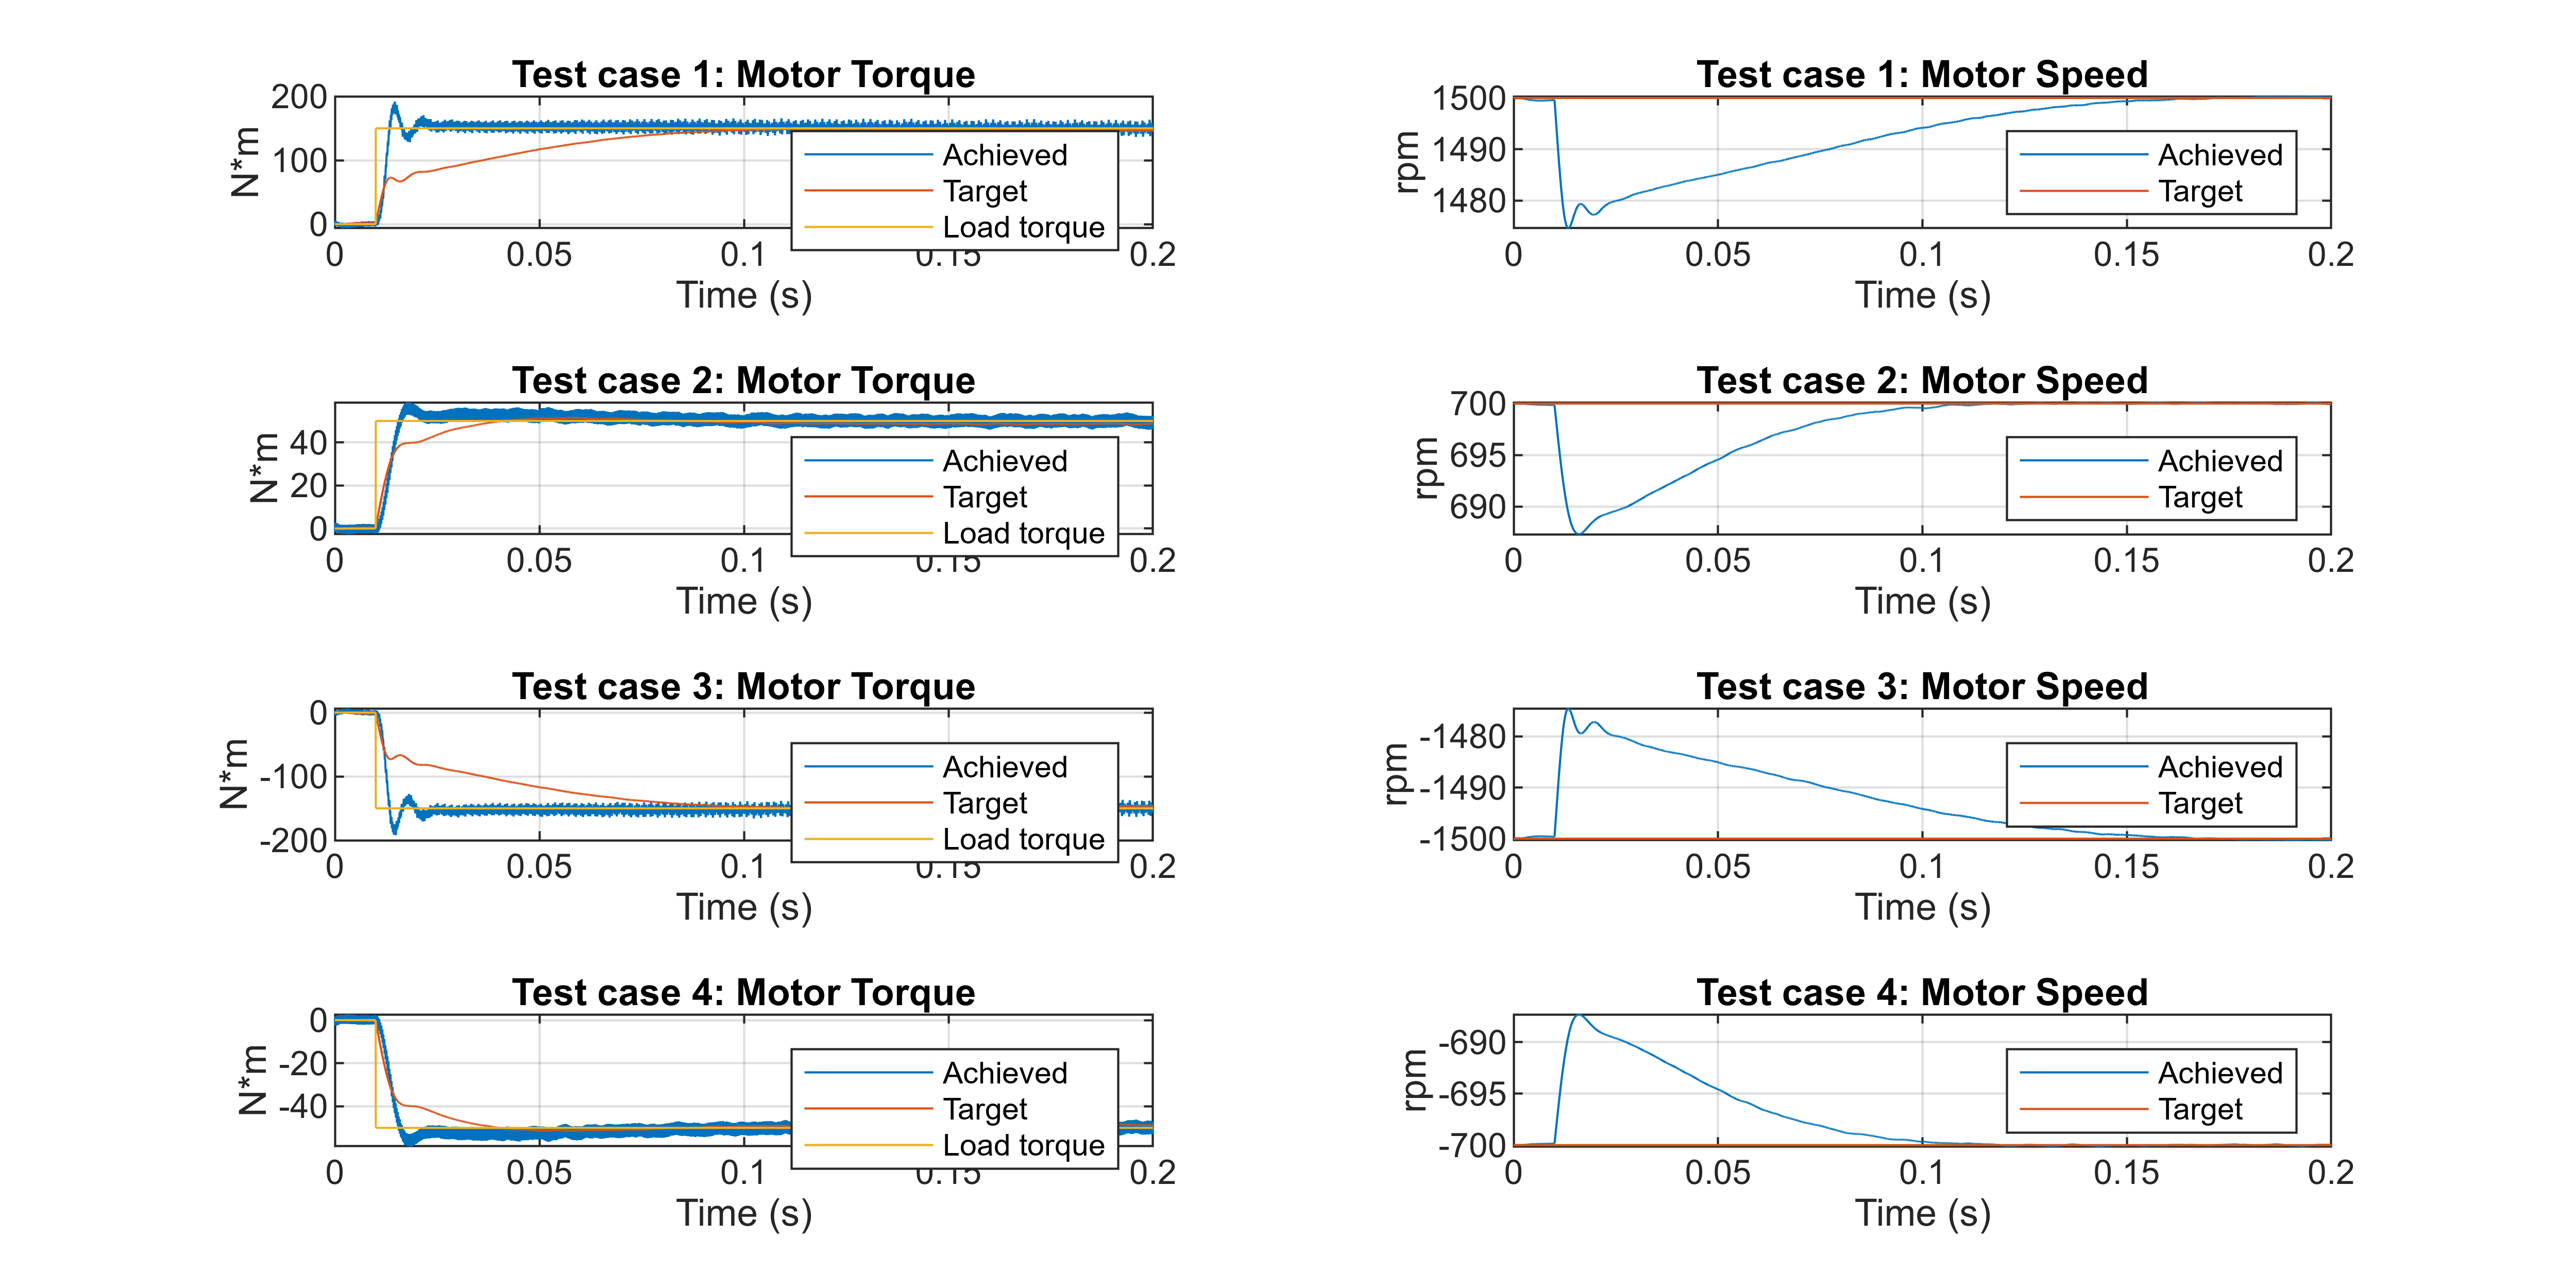

In [2]:
f = figure;
f.Position(3:4) = [800 400];
tiledlayout(nSims,2)
for idx = 1:nSims
  nexttile
  series = out(idx).logsoutssc.Motor_Drive.Encoder.Torque_Sensor.t.series;
  plot(series.time, series.values("N*m"))
  hold on;  grid on
  vals = out(idx).logsout.get("FOC_TrqRef_Nm").Values;
  plot(vals.Time, vals.Data)
  vals = out(idx).logsout.get("Load Torque").Values;
  plot(vals.Time, vals.Data)
  title("Test case "+num2str(idx)+": Motor Torque")
  ylabel("N*m");  xlabel("Time (s)")
  legend("Achieved", "Target", "Load torque")
  hold off

  nexttile
  % Updated w to W:
  series = out(idx).logsoutssc.Motor_Drive.Encoder.Rotational_Motion_Sensor.W.series;
  plot(series.time, series.values("rpm"))
  hold on;  grid on
  vals = out(idx).logsout.get("Target Speed").Values;
  plot(vals.Time, vals.Data)
  title("Test case "+num2str(idx)+": Motor Speed")
  ylabel("rpm");  xlabel("Time (s)")
  legend("Achieved", "Target")
  hold off
end


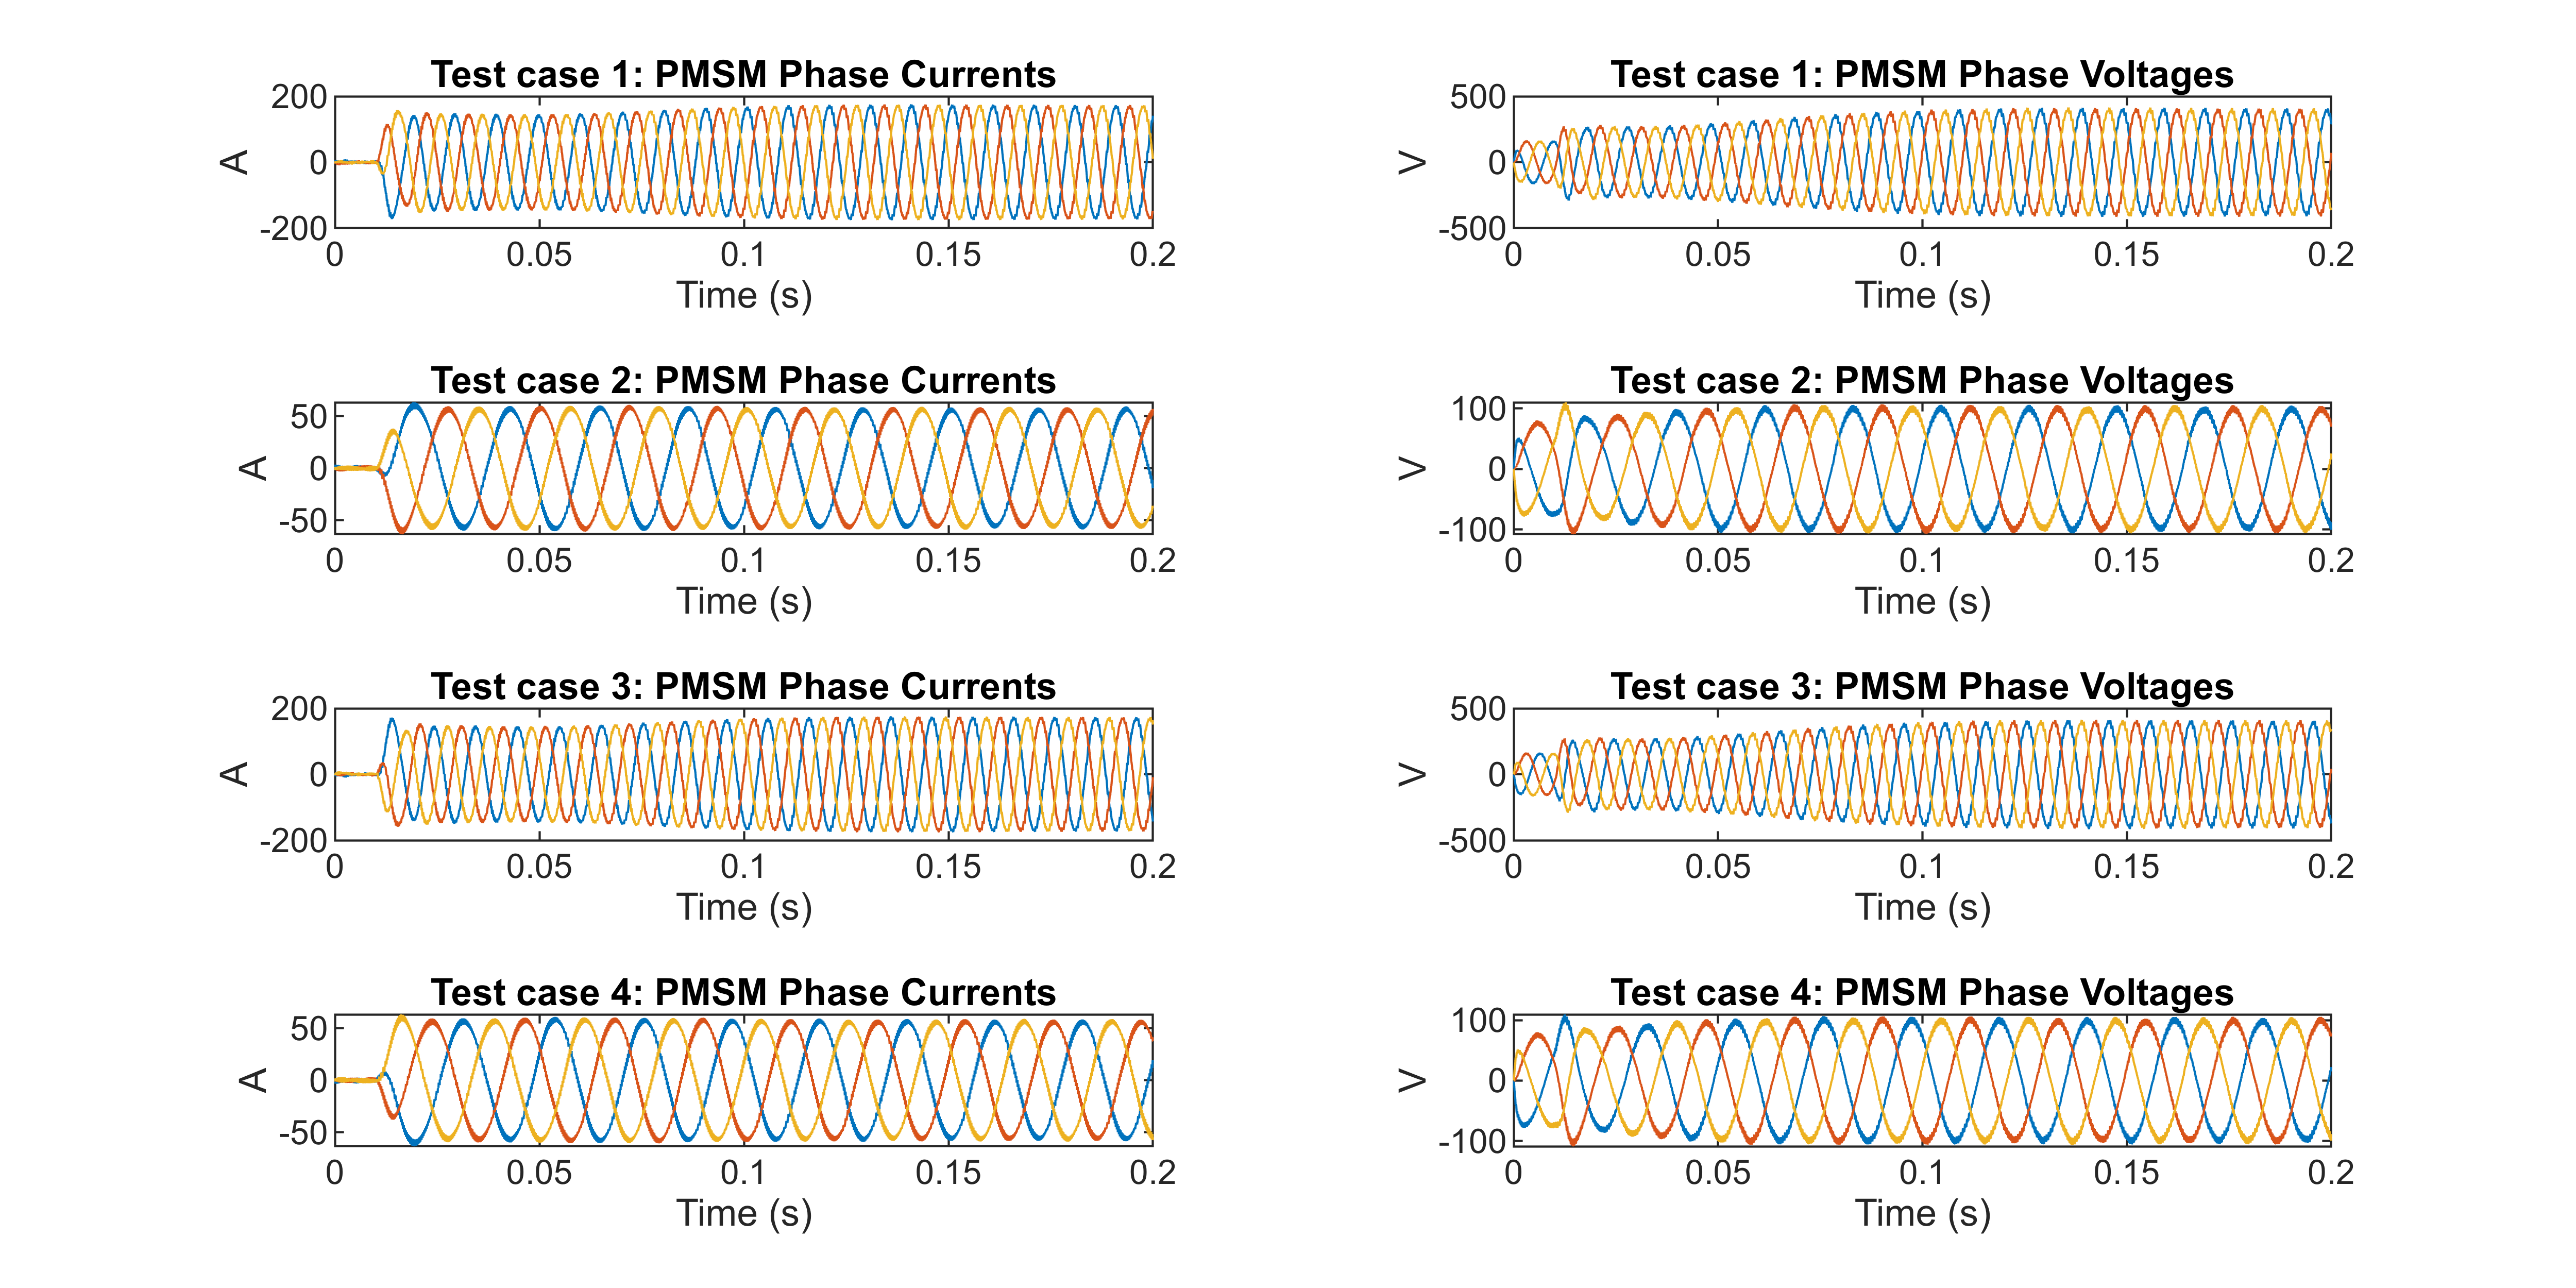

In [3]:
f = figure;
f.Position(3:4) = [800 400];
tiledlayout(nSims,2)
for idx=1:nSims
  nexttile
  vals = out(idx).logsout.get("PMSM Phase Currents").Values;
  plot(vals.Time, vals.Data)
  ylabel("A");  xlabel("Time (s)");
  title("Test case "+num2str(idx)+": PMSM Phase Currents")

  nexttile
  vals = out(idx).logsout.get("PMSM Phase Voltages").Values;
  plot(vals.Time, vals.Data)
  ylabel("V");  xlabel("Time (s)");
  title("Test case "+num2str(idx)+": PMSM Phase Voltages")
end